# Overfitting in the centralized model?
---


:::: {style="display: flex; "}

:::

### 99a_insurance_centralized_wrapup.ipynb

**No Overfitting**

![](../output/experiments/00_central/results/training_performance.png)

:::

:::

### 99b_insurance_federated_wrapup.ipynb

**Overfitting**


![](../output/experiments/02_central_new/results/training_performance_rsq.png)


:::

::::

## Setup
---

### Imports
---

In [1]:
# imports

# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed
# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model, train_fed, plot_hist
#train_model,
#import FLutils

# logging path
log_path = '../output/experiments/04_debug/' 

### Data
---

In [2]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']#[:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Model specifics
---

In [4]:
# model
model = create_keras_model(compile = True)
model.summary()
model.get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

In [5]:
print('Defaults of FLutils.train_model')

dict(zip(
    train_model.__code__.co_varnames[3:-3],
    train_model.__defaults__
))

# S. help(train_model)

Defaults of FLutils.train_model


{'epochs': 100,
 'batch_size': 128,
 'shuffle': True,
 'validation_split': 0.2,
 'verbose': 0,
 'output_msr': 'loss',
 'seed': 42}

## Experiments
---

In [6]:
n_epochs = 100
n_folds = 5
n_reps = 1

### Complete Data
---

In [7]:
experiment_name = "test00_complete_data"        # logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

In [8]:
eval_name = ""      # train + eval

X_train, y_train = df[features], df[target]

model = create_keras_model(compile = True)

hist = train_model(
    model, X_train, y_train, 
    epochs = n_epochs, 
    output_msr = "r2_score",
    callbacks = [CSVLogger(
        "%s/logs/log_%s_%s.csv" % 
        (experiment_path, eval_name, experiment_name)
        
        #experiment_path + "/logs/" + eval_name + '_log.csv'  , separator =";"
        )]
    )

plot_hist(
    hist.history, title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


### Stratified K fold
---

In [ ]:
experiment_name = "test01_Stratified5Fold"        # logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

r2_score  = 0.7407, time = 4.0 sec
r2_score  = 0.7401, time = 4.2 sec
r2_score  = 0.7428, time = 4.1 sec
r2_score  = 0.7290, time = 4.2 sec
r2_score  = 0.7507, time = 4.2 sec


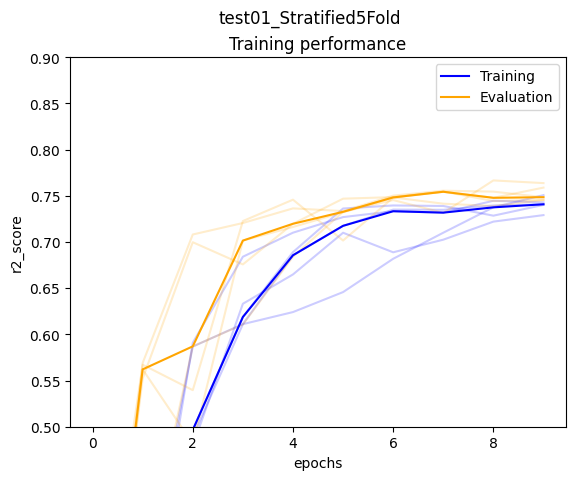

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
hists = []

i = 0
for train, _ in cv.split(df, df.region): 
    
    eval_name = "fold" + str(i)
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


### K fold
---

In [ ]:
experiment_name = "test02_5Fold"        # logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

r2_score  = 0.7090, time = 4.0 sec
r2_score  = 0.7394, time = 3.9 sec
r2_score  = 0.7428, time = 3.9 sec
r2_score  = 0.7259, time = 3.9 sec
r2_score  = 0.7222, time = 3.9 sec


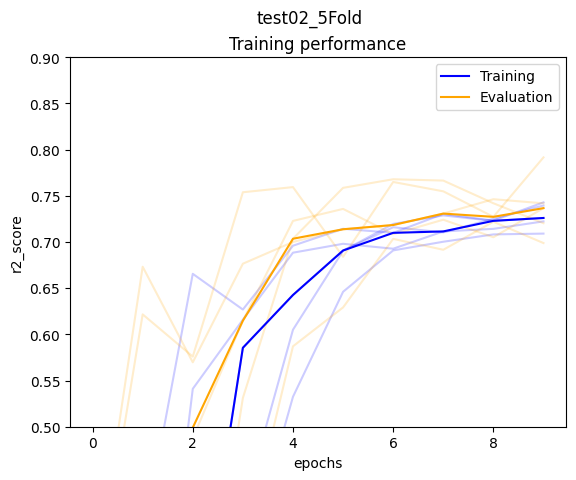

In [ ]:
cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
hists = []

i = 0
for train, _ in cv.split(df, df.region): 
    
    eval_name = "fold" + str(i)
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)

## Analysis
---

In [ ]:
experiments = os.listdir("../output/experiments/04_debug")

logs = []
for ex in experiments:
    log_files = os.listdir("../output/experiments/04_debug/%s/logs" % ex)
    for log_file in log_files:
        log_path = "../output/experiments/04_debug/%s/logs/%s" % (ex, log_file)
        logs.append(pd.read_csv(log_path).assign(experiment = ex))
    

In [ ]:
pd.concat(logs).head()

,epoch,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score,experiment
0,0,315228448.0,13081.663086,315228448.0,-1.204525,305631328.0,12456.115234,305631328.0,-1.189895,test00_complete_data
1,1,210737536.0,9778.693359,210737536.0,-0.388819,127567168.0,9916.198242,127567168.0,-0.013443,test00_complete_data
2,2,117119808.0,9106.458008,117119808.0,0.178305,104489032.0,6847.667969,104489032.0,0.308851,test00_complete_data
3,3,85375824.0,6658.377441,85375824.0,0.415957,72432736.0,7273.220215,72432736.0,0.438233,test00_complete_data
4,4,62560272.0,6752.290527,62560272.0,0.560283,55664168.0,4991.986816,55664168.0,0.603045,test00_complete_data


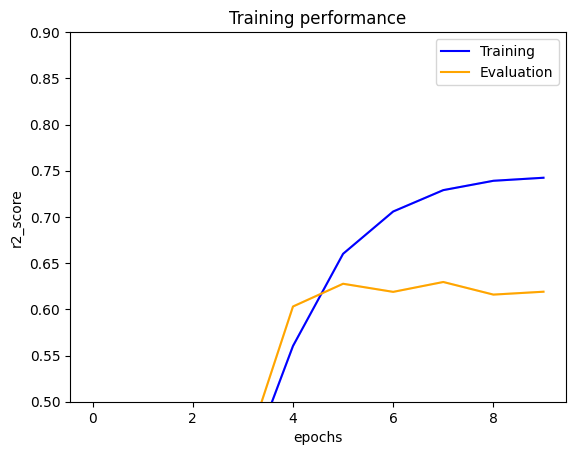

In [ ]:
for log in logs[:1]:
    plot_hist(log)

# Appendix